# Apresentação:

O objetivo do código é explorar a funcionalidade da classe `pipeline` da [HuggingFace](https://huggingface.co/) no contexto de LLMs (Modelos de Linguagem de Grande Escala), demonstrando como realizar tarefas de inferência em NLP de forma prática e eficiente. Para isso, vamos utilizar o modelo **DistilBERT-base-uncased-finetuned-sst-2-english** para realizar uma **análise de sentimentos** em comentários extraídos de um [fórum](https://www.techpowerup.com/forums/threads/black-myth-wukong-game-thread.325737/) na internet.

In [1]:
# Importando Pipeline:
from transformers import pipeline

O `pipeline()` simplifica o uso de qualquer modelo do [Hub](https://huggingface.co/models) para inferência em qualquer linguagem, visão computacional, fala e tarefas multimodais. Mesmo que não se tenha experiência com uma modalidade específica ou não esteja familiarizado com o código subjacente aos modelos, ainda poderá usá-los para inferência com esse método. A ideia aqui é ser uma espécie de "amostra grátis" do [Hugging Face](https://huggingface.co/).

No concurso do BNDES eles só vão cobrar o hugging face no contexto dos modelos de Linguagem, LLMs. Então, aqui eu vou focar nessas modelos.

# Descrição do modelo:

Este modelo é um ponto de verificação de ajuste fino do DistilBERT-base-uncased, ajustado no SST-2. Este modelo atinge uma precisão de 91,3 no conjunto de desenvolvimento (para comparação, a versão Bert bert-base-uncased atinge uma precisão de 92,7).


In [2]:
# Instanciando Modelo:
classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
C:\Users\amori\anaconda3\envs\bndes\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
# Teste:
classifier("We are very happy to show you the 🤗 Transformers library.")

[{'label': 'POSITIVE', 'score': 0.9997795224189758}]

# Scraping:

Para testar a utilização do classificador para análise de sentimentos, eu vou fazer um scraping de da internet para gerar algumas frases, e avaliar esses resultados. Para esse fim, vou pegar alguns comentários sobre o jogo [Black Myth: Wukong](https://store.steampowered.com/app/2358720/Black_Myth_Wukong/) em um fórum na internet.

In [4]:
# Importando Biblioteca de Web Scraping:
import requests
from bs4 import BeautifulSoup

In [5]:
# site:
url = "https://www.techpowerup.com/forums/threads/black-myth-wukong-game-thread.325737/"

In [6]:
# Aquisição dos dados:
headers = {'user-agent':'Mozilla/5.0'}

# Requisição dos dados:
resposta = requests.get(url);resposta

<Response [200]>

In [7]:
# Gerando Parser:
html = BeautifulSoup(resposta.text,'html.parser')

In [8]:
# Encontrando Elementos:
meta_tags = html.find_all("div", class_="bbWrapper")

# Extraindo Mensagens:
msgs = [div.get_text(strip=True) for div in meta_tags];msgs

["There will be a lot of performance talk here; and a lot of back and fourth. Lets keep in mind its a game thread and keep as much game play, screen shots and other game relevant content in it as possible.Shader compilation took a few minutes. Then it sat getting ready for something. Loading screen is nice. The murals are gorgeous. They definitely used mega scans. The texture detail on some things is amazing. I honestly dont know if I would put it over hellblade 2; but it definitely has its moments. The sound in this is also good. Can't wait to get further in.",
 "Hellblade 2 has nanite on vegetation this doesn't and the character models while good are better in Hellblade 2 otherwise all other aspects are better in this at least visually especially with full RT.It does have traversal stutter although it's less apparent the lower your framerate.",
 "Regardless of some hiccups, I've gotten and am downloading the game right now ...",
 'Looks impressive',
 'This game might need to wait unt

# Avaliando Sentimentos:

O modelo de análise de sentimentos padrão é o [Distilbert](https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).

## Modelo DistilBERT base (uncased)
Este modelo é uma versão reduzida do modelo BERT base, da própria [Hugging Face](https://huggingface.co/distilbert/distilbert-base-uncased), cuja o paper que o introduz é o [DistilBERT, a distilled version of BERT: smaller,
faster, cheaper and lighter](https://arxiv.org/pdf/1910.01108). O código para o processo de distilação pode ser encontrado [aqui](https://github.com/huggingface/transformers/tree/main/examples/research_projects/distillation). Este modelo é "uncased": ele não diferencia entre "english" e "English", por exemplo.

## Descrição do modelo
O DistilBERT é um modelo de transformadores, menor e mais rápido que o BERT, que foi pré-treinado no mesmo corpus de maneira auto-supervisionada, usando o modelo BERT base como professor. Isso significa que foi pré-treinado apenas com textos brutos, sem intervenção humana para rotular os dados de qualquer maneira (por isso, ele pode usar muitos dados publicamente disponíveis), utilizando um processo automático para gerar entradas e rótulos a partir desses textos, usando o modelo BERT base. Mais precisamente, ele foi pré-treinado com três objetivos:

* **Perda por distilação:** o modelo foi treinado para retornar as mesmas probabilidades que o modelo BERT base.

* **Modelagem de linguagem mascarada (MLM):** esta é parte da perda original de treinamento do modelo BERT base. Ao processar uma sentença, o modelo mascara aleatoriamente 15% das palavras da entrada, então passa a sentença inteira mascarada pelo modelo e tem que prever as palavras mascaradas. Isso é diferente dos modelos tradicionais de redes neurais recorrentes (RNNs), que geralmente veem as palavras uma após a outra, ou dos modelos autorregressivos, como o GPT, que mascaram internamente os tokens futuros. Isso permite que o modelo aprenda uma representação bidirecional da sentença.

* **Perda de similaridade de cosseno:** o modelo também foi treinado para gerar estados ocultos o mais próximo possível do modelo BERT base.

In [9]:
# Bibliotecas:
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# Avalisando Mensagens:
resultados = {'label':[],'score':[]}
for msg in tqdm(msgs):
    saida = classifier(msg)
    resultados['label'].append(saida[0]['label'])
    resultados['score'].append(saida[0]['score'])

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00,  8.56it/s]


In [11]:
df = pd.DataFrame(resultados, columns=resultados.keys());df

,label,score
0,POSITIVE,0.999747
1,NEGATIVE,0.964581
2,POSITIVE,0.952944
3,POSITIVE,0.999874
4,NEGATIVE,0.999369
5,POSITIVE,0.595238
6,NEGATIVE,0.985281
7,POSITIVE,0.966957
8,NEGATIVE,0.857865
9,POSITIVE,0.989763


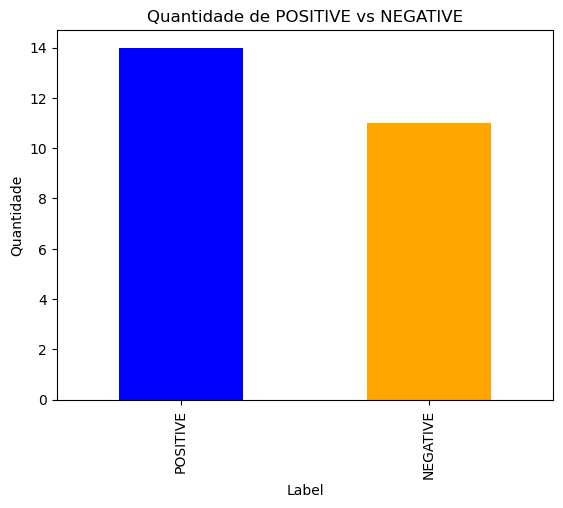

In [12]:
# Contar os valores
counts = df['label'].value_counts()

# Plotar o gráfico de barras
counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Quantidade de POSITIVE vs NEGATIVE')
plt.xlabel('Label')
plt.ylabel('Quantidade')
plt.show()

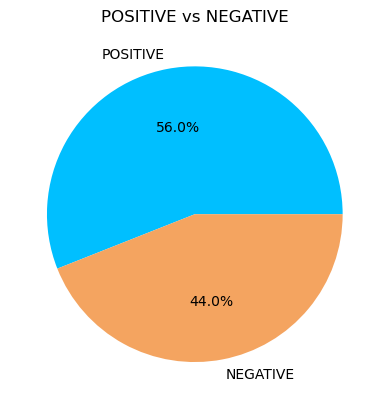

In [13]:
# Plotar o gráfico de pizza
counts.plot(kind='pie', autopct='%1.1f%%', colors=['#00BFFF', '#F4A460'])
plt.title('POSITIVE vs NEGATIVE')
plt.ylabel('')  # Remove o label padrão do eixo y
plt.show()